## harvard꺼 따라가보자

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

### encoder decoder 구조이다.
- mask로 못보는곳과 필요없는곳 attention안가게 조정하면서 encoder, decoder 먹인다.

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed  # 하위에서 encode 메서드를 호출할때 사용될 것이다. embeding & positional encoding 적용
        self.tgt_embed = tgt_embed  # decode할때 쓰는건데, 이게 forward와 별개로 구성하기 위함이 좀 있다.
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### generator를 따로둬서 마지막에 나온 vector를 vocab으로 매핑한다

In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### encoder든 decoder는 스택쌓아서 하니까 관련 함수를 만들어 써보자

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Encoder는 n번의 encoder layer를 쌓고 layer norm을 한다.
- 참고로 layernorm 아직 정의안했다.

In [6]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### layer norm은 transformer와 별개의 기법이지만 좋으니까 쓰나보다.
- 방식은 layer size를 받아서 훈련이 가능한 weight 가중치를 만든다.
  - batch norm마냥 결과를 normalize하고 적당히 가중치를 곱하고 더해주는데 이거 사실상 조정이라 생각한다.

In [7]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Encoder Layer를 만들기 전에 좀 더 깔끔히 만들라고 중복코드 반출
> encoder layer는 multi head attention block랑 position wise fully connected FF net의 두개블럭이있는데. 각각의 블럭은 residual이라 residual 모듈을 미리 만들엇다.

In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### encoder layer를 그래서 대충 붙이면 아래처럼된다.
- 대충 눈으로 봐도 알겠지만 sublayer를 attention이랑 ff블럭에 각각붙여서 순서대로 먹인다

In [9]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### decoder도 사실 똑같이 반복이라는  아래의 코드이다. 
- 입력에서 신경쓰이는 다른것들이 있지만 이건 나중에 알게된다.

In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### decoder layer는 3단계다.
- 이전까지의 자기끼리 참고하는 attention
- source에서 참고할걸 찾아가는 attention
- 정돈을 위한 feedforward

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

### decoder의 마스크를 먼저 만들어보자
- 훈련단계에서는 자기 이전의 출력만 볼 수 있는데 그걸 마스크로 만들면 대충 다음처럼 나온다.
- 아까 공부할때도 미묘했지만 그냥 tril을 쓰면 안되나 싶다.

In [17]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def subsequent_mask2(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.tril(np.ones(attn_shape)==1)
    return torch.from_numpy(subsequent_mask)

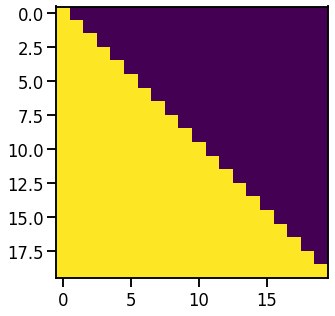

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [19]:
subsequent_mask(5)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

In [20]:
subsequent_mask2(5)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

### attention
- q, k, v를 입력받아서 mask먹이고 attention을 구하는 이친구를 봐보자.

In [21]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # 맨마지막은 무조건 d_k인것을 check
    d_k = query.size(-1)
    
    # 맨마지막에서 2번째는 seq_len임을 check
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [22]:
False == 0

True

### 여러 파츠를 참고하고 싶으니까 multi head attention을 채용한다.
- 그냥 중간 결과를 나누어서 attention을 한다.

In [26]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        # 3개는 q k v꺼, 1개는 리폼용
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        
        # 1번 dim이 head의 차원이라고 위에서 정하고 0번 차원이 batch 라고 정했음.
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # linear로 곱하고 나서 자르는데, 자르고 batch, head, seqlen, dk가 되도록 view를 먹임
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        # 특이한게 attention의 정의는 3개의 dim짜리로 했는데 4개의 dim으로 확장해도 어떻게 되는게 신기하다.
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        # x에는 attn이 먹여진 결과가 이미 들어가 있는데 다시 합치기 위해서 head 를 2번으로 옮겨주고 view를 사용할 수 있게, contiguous()를 먹인다.
        # view로 원래의 batch, seq_len, d_embeded로 복귀한다.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [25]:
# clone 4번째는  concat한거 리폼용이다.
for i, j in zip([1, 2, 3, 4], (5, 6, 7)):
    print(i, j)

1 5
2 6
3 7


### PositionwiseFeedForward 요거 디게 별거없다 늘렷다 줄엿다 하면 끝이다.

In [27]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 이제 입력 데이터를 손봐보자
- 데이터는 2단계로 구성되는데
  - vocab -> d_embded로 바꾸는 매핑과정 참고로 int넣어서 vector나온다
  - positional encoding을 추가하는 과정 (sin, cos랑 주기가 적당히 엮여서 나오는 함수인데 수식으로 이해하자)

In [28]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [29]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

## 아래 그림보면 dim마다 다른 주기를 같는 positional encoding을 볼 수 있다.

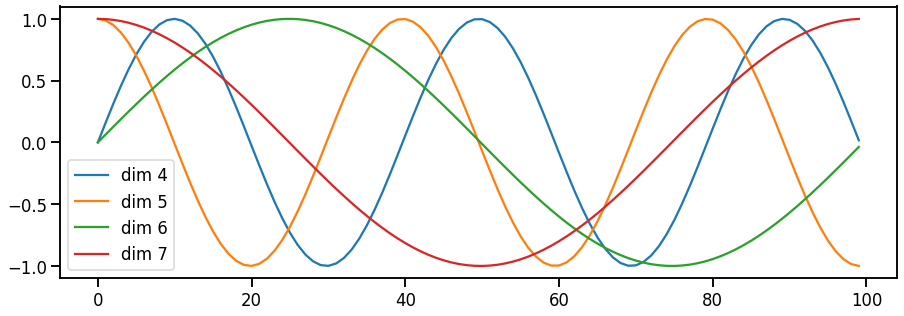

In [30]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [32]:
Variable(torch.zeros(1, 100, 20))
# positional encoding은 dim과 seq time에 의존적

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

### 각각의 구성이 복잡한 만큼 make model은 짧고 밀도가 크다. 잘 읽어보자

In [33]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy # 여러번쓸 layer 정보를 주소 안겹치게 주기위함
    attn = MultiHeadedAttention(h, d_model) # attention은 고정적으로 h개의 head와 출력 dim을 d_model로 하겠다고 선언
    ff = PositionwiseFeedForward(d_model, d_ff, dropout) # 중간 hidden unit수가 2048이 되게 정돈하는 ff만 쓰겟다고 선언
    position = PositionalEncoding(d_model, dropout) #  입력에만 쓰겟지만 일단 positional encoding 모듈을 구성
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)), 
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)), # tgt_vocab이 다를 수 있다. 번역같은경우
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

### batch랑 mask를 만들어보자
- 위에서 정의했던 subsequent_mask를 쓰는데 했갈리니까 그냥 아래로 끌고왔다.

In [34]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def subsequent_mask2(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.tril(np.ones(attn_shape)==1)
    return torch.from_numpy(subsequent_mask)


class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # 느낌이 오겠지만, src는 이미 패딩되어있다.
        # 여기서 왜 unsqueeze를 해주는가 하면 기본은 batch, seqlen인데 이걸 batch, 1, seqlen으로 바뀌게 된다.
        # 이게 왜 필요한가하면, 나중에 decoding을 할 때, 잘보면 1개씩 늘어나는데 seq[:1], seq[:2], ---, seq[:seqlen]까지 총 n개가 들어갈거고
        # 그거에 따라서 target mask를 위에서 정의한 subsequent_mask로 만들것이다. 즉, 하나의 seq에서 여러 배치를 돌릴꺼니까 미리 dim을 증축하는 것이다.
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        
        # target이 있으면 trg관련 mask를 만드려 하는듯하다.
        
        
        
        if trg is not None:
            # 첫 두줄의 의미는 각각 다음걸 예측할거니까 input / output이 연속 관계니까 멘뒤자르고 맨앞잘라서 trg in과 trg out으로 나눈거다
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            # mask를 어떻게 만드는지는 아레에 함수를 따로 정의한다.
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum() # 요거 data가 무슨 의미가 있을지 모르겠다 없어도 작동은 잘한다.
    
    @staticmethod
    # 여기서 짚고 넘어가야하는건 tgt는 타겟이라고 적었으면서 실제는 과거 값 즉 입력이다.
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        # 기본은 일단 끊긴 부분은 죽이는거다.
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # seqlen만큼 순차적으로 배치를 만들거라 dim이좀 커진다. batch, seqlen, seqlen이 된다.
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [38]:
a = torch.Tensor([[1,2,3,0,0,0], [1,2,3,4,5,0]])
a

tensor([[1., 2., 3., 0., 0., 0.],
        [1., 2., 3., 4., 5., 0.]])

In [39]:
a != 0

tensor([[ True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False]])

In [40]:
(a != 0).unsqueeze(-2)

tensor([[[ True,  True,  True, False, False, False]],

        [[ True,  True,  True,  True,  True, False]]])

In [42]:
(a != 0).unsqueeze(-2).sum()

tensor(8)

In [47]:
tgt_mask = (a != 0).unsqueeze(-2)
print(tgt_mask)
print('@'*20)
tgt_mask = tgt_mask & Variable(subsequent_mask(a.size(-1)).type_as(tgt_mask.data))
print(tgt_mask)
print('@'*20)

tensor([[[ True,  True,  True, False, False, False]],

        [[ True,  True,  True,  True,  True, False]]])
@@@@@@@@@@@@@@@@@@@@
tensor([[[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True, False, False, False]],

        [[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True, False]]])
@@@@@@@@@@@@@@@@@@@@


### training 과정은 꽤 단순해진다
- data를 모델에 넣고 loss를 구하는것 즉 세개의 원소를 입력으로주면된다.

In [48]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### 요거는 batch size를 정하기 위해서  대충 얼마나큼 데이터들이 들어가는지 알아내는 함수이다.

In [49]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2) # 요거는 start token이랑 end token이 필요해서 2개만큼 더 길어진다
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

### 슬슬 거의다왔다 이제 Optimizer이다.
- adam을 쓰는데 세부 스케줄러를 봐보면 초반에 lr을 늘려가는 warmup기법과 점차적으로 lr을 낮추는 기법을 섞는다.
- optimier는 step을 갖는 함수면되는듯하다.
  - step은 optimizer가 갖는 기본 내장변수로, optimizer.param_groups의 p가 갖는 lr이라는 원소에 따라 weight에 변화를 주게된다.

In [50]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Label Smoothing이라는 기법을 적용하는데 일단 살펴보자
- [Link](https://3months.tistory.com/465)요거인데 그냥 적당히 상수로 정해진 smoothing을 적용하는 것이다. 사실상 학습량 조절이라 보면될듯

In [87]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing # 요거만큼 죽일거란거다
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2)) # eos랑 지금 값은 아닐거라서 빼주는듯하다.
        print(true_dist)
        print('-'*89)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # onehop을 먹일건데 주는 값이 self.confidence 요거다
        print(true_dist)
        print('-'*89)
        true_dist[:, self.padding_idx] = 0
        print(true_dist)
        print('-'*89)
        mask = torch.nonzero(target.data == self.padding_idx) # 특이하게 좌표로 그냥준다.
        
        print(mask)
        print('-'*89)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            print(true_dist)
            print('-'*89)
        self.true_dist = true_dist
        print(true_dist)
        print('-'*89)
        return self.criterion(x, Variable(true_dist, requires_grad=False))

tensor([[   -inf, -1.6094, -0.3567, -2.3026,    -inf],
        [   -inf, -1.6094, -0.3567, -2.3026,    -inf],
        [   -inf, -1.6094, -0.3567, -2.3026,    -inf]])
tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])
-----------------------------------------------------------------------------------------
tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])
-----------------------------------------------------------------------------------------
tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
-----------------------------------------------------------------------------------------
tensor([[2]])
-----------------------------------------------------------------------------------------
tensor(

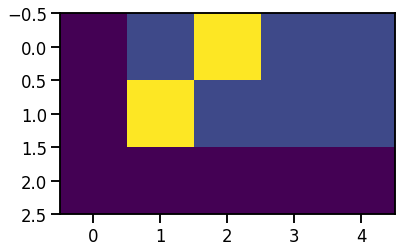

In [88]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
print(predict.log())
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
print(crit.true_dist)
None

In [91]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

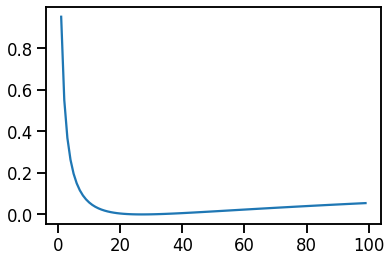

In [100]:
crit = LabelSmoothing(5, 0, 0.1)
def losss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).data
y = [losss(x) for x in range(1, 100)]
plt.plot(np.arange(1, 100), y)
None

## First Example
- https://crmn.tistory.com/105 
- 요거 참고해서 에러뜨는거 고쳤다. invalid data[0]인데 torch 구조가 바껴서 0.5버젼 전후로 표현이 차이가 나게된것

In [95]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))) # batch * seqlen = 10인 Vocab이 V일때, 랜덤으로 데이터 생성
        data[:, 0] = 1 # 모든 배치에서 첫번째 seq는 1번인데 이게아마 start token의 의미가 아닐까 생각중
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0) # 입력과 출력이 같은 dataset

In [98]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator # 모델
        self.criterion = criterion # 로스
        self.opt = opt # 옵티마이저
        
    def __call__(self, x, y, norm):
        x = self.generator(x) # 모델 마지막 레이어 태운거임
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm

In [99]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

<ipython-input-33-7c0419a3f06e>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.067028 Tokens per Sec: 422.079895
Epoch Step: 1 Loss: 1.862613 Tokens per Sec: 1838.185669
tensor(1.9198)
Epoch Step: 1 Loss: 1.929455 Tokens per Sec: 1210.338257
Epoch Step: 1 Loss: 1.798662 Tokens per Sec: 1874.359985
tensor(1.7495)
Epoch Step: 1 Loss: 1.869911 Tokens per Sec: 795.406006
Epoch Step: 1 Loss: 1.364925 Tokens per Sec: 1846.137207
tensor(1.3501)
Epoch Step: 1 Loss: 1.599294 Tokens per Sec: 821.997681
Epoch Step: 1 Loss: 0.942439 Tokens per Sec: 1481.386353
tensor(0.9878)
Epoch Step: 1 Loss: 1.371272 Tokens per Sec: 821.260559
Epoch Step: 1 Loss: 0.756072 Tokens per Sec: 1880.031006
tensor(0.7404)
Epoch Step: 1 Loss: 0.802385 Tokens per Sec: 953.045532
Epoch Step: 1 Loss: 0.336404 Tokens per Sec: 1624.859497
tensor(0.4143)
Epoch Step: 1 Loss: 0.702808 Tokens per Sec: 926.205750
Epoch Step: 1 Loss: 0.225505 Tokens per Sec: 1978.324341
tensor(0.2708)
Epoch Step: 1 Loss: 0.557057 Tokens per Sec: 850.692383
Epoch Step: 1 Loss: 0.233830 Tokens per Sec: 20

# Real World Example
> 독일어 / 영어 번역문제 해보자
> spacy는 데이터 불러오는 모듈인데 [link](https://wotres.tistory.com/entry/spacy-%EB%AA%A8%EB%93%88-%EC%82%AC%EC%9A%A9%EC%8B%9C-Cant-find-model-en-It-doesnt-seem-to-be-a-shortcut-link-a-Python-package-or-a-valid-path-to-a-data-directory-%EC%97%90%EB%9F%AC-%ED%95%B4%EA%B2%B0%EB%B2%95) 요거 참고하면 설치가 편하다

In [117]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    print(spacy.__version__)
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]
    
    print(spacy_de.__dict__)
    print(spacy_en)
    

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)
    
    print(SRC)
    print(TGT)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de_core_news_sm', '.en_core_web_sm'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

3.0.6
{'_config': {'paths': {'train': 'corpus/de-dep-news/train.spacy', 'dev': 'corpus/de-dep-news/dev.spacy', 'vectors': None, 'raw': None, 'init_tok2vec': None, 'vocab_data': None}, 'system': {'gpu_allocator': None, 'seed': 0}, 'nlp': {'lang': 'de', 'pipeline': ['tok2vec', 'tagger', 'morphologizer', 'parser', 'senter', 'ner', 'attribute_ruler', 'lemmatizer'], 'disabled': ['senter'], 'before_creation': None, 'after_creation': None, 'after_pipeline_creation': None, 'batch_size': 256, 'tokenizer': {'@tokenizers': 'spacy.Tokenizer.v1'}}, 'components': {'attribute_ruler': {'factory': 'attribute_ruler', 'validate': False}, 'lemmatizer': {'factory': 'lemmatizer', 'mode': 'lookup', 'model': None, 'overwrite': False}, 'morphologizer': {'factory': 'morphologizer', 'model': {'@architectures': 'spacy.Tagger.v1', 'nO': None, 'tok2vec': {'@architectures': 'spacy.Tok2VecListener.v1', 'width': '${components.tok2vec.model.encode:width}', 'upstream': '*'}}}, 'ner': {'factory': 'ner', 'moves': None, 'u

ReadError: not a gzip file

In [121]:
import torchtext
torchtext.__version__

'0.8.0a0+0f911ec'

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

In [ ]:
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [ ]:
devices = [0]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

In [ ]:
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break